# Пересечение множества отрезков
Перед нами стоит задача: дано множество $S$, состоящее из $n$ отрезков на плоскости. Нам нужно найти все точки их пересечений. 

Очевидно, что наивный алгоритм, переберающий все пары отрезков, имеет сложность $O(n^2)$. В некотором смысле это оптимальная оценка, так как в случае, когда каждая пара отрезков из множества пересекается, любой алгоритм займет $\Omega(n^2)$ времени. Однако на практике такие ситуации встречаются редко, обычно пересечений гораздо меньше. Поэтому хотелось бы уметь решать данную задачу быстрее в таких ситуациях. Другими словами, нужен алгоритм, время работы которого будет зависеть не только от $n$, но и от количества пересечений. Такие алгоритмы называются *output-sensitive*. 

В этом конспекте мы научимся решать поставленную задачу за время $O((n + I)\log{n})$, где $I$ - количество персечений. Кроме этого мы рассмотрим несколько смежных задач.

## План конспекта
- Предикат "левый поворот"
 - Наивная реализация
 - Проблемы наивной реализации
 - Расчет погрешности вычисления поворота в числах с плавающей точкой
 - Реализация с учетом погрешностей
- Задача о пересечении двух отрезков
 - Теория
 - Реализация
- Алгоритм Бентли-Оттмана
 - Теория
 - Упражнение

## Предикат "Левый поворот"
Это простейший геометрический предикат, который позволяет проверять, пересекается ли пара отрезков, лежит ли точка внутри треугольника и многое другое. Он принимает на вход три точки плоскости $(a, b, c)$ и возвращает следующие значения:

$$ \begin{equation*}
turn(a, b, c) = 
 \begin{cases}
   1, &\text{если c лежит слева от направленного отрезка ab,}\\
   -1, &\text{если c лежит справа от направленного отрезка ab,}\\
   0, &\text{если три точки лежат на одной плоскости.}
 \end{cases}
\end{equation*} $$

Предикат вычисляется с помощью векторного произведения:

$$ turn(a, b, c) = sign((b - a) \times (c - a)) = sign 
\left( \begin{array}{cc}
  \left| \begin{array}{cc}
    b_x - a_x & c_x - a_x\\
   b_y - a_y & c_y - a_y
  \end{array} \right| 
\end{array} \right) $$

Рассмотрим результат такого наивного вычисления поворота от отрезка и точки плоскости: красный цвет - левый поворот, синий - правый, зеленый - точка и отрезок принадлежат одной прямой: 

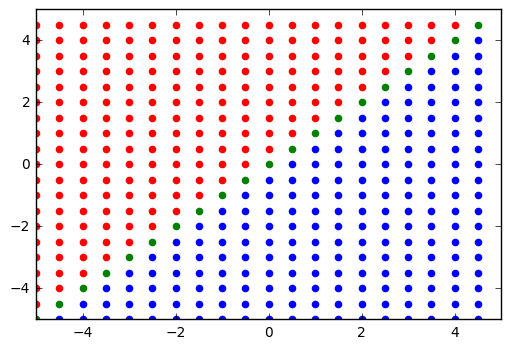

In [11]:
import matplotlib.pyplot as plt
import numpy as np

class Point:
    def __init__(self, x = 0.0, y = 0.0):
        self.x = x
        self.y = y

    def __add__(self, p):
        return Point(self.x + p.x, self.y + p.y)

    def __sub__(self, p):
        return Point(self.x - p.x, self.y - p.y)

    def __neg__(self):
        return Point(-self.x, -self.y)

    def __repr__(self):
        return "(%r, %r)" % (self.x, self.y)

max_val = 5
step = 0.5
colors = ["r","g", "b"]

def calculate_det(a, b):
    return a.x * b.y - b.x * a.y

def turn(a, b, c):
    det = calculate_det(b - a, c - a)
    if det > 0:
        return colors[0]
    if det < 0:
        return colors[2]
    return colors[1]

x = Point(-max_val, -max_val)
y = Point(max_val, max_val)
for x_i in np.arange(-max_val, max_val, step):
    for y_i in np.arange(-max_val, max_val, step):
        color = turn(x, y, Point(x_i, y_i))
        plt.scatter(x_i, y_i, color = color, s = 20)

plt.axis([-max_val, max_val, -max_val, max_val])
plt.show()

Однако у такого решения есть проблема: попробуем посчитать поворот точек $p1 = (1.1016, 8.1672)$, $p2 = -p1$ и $p3 = p1 * (1 << 52)$:

In [2]:
p1 = Point(1.1016, 8.1672)
p2 = -p1
p3 = Point(p1.x * (1 << 52), p1.y * (1 << 52))
print("Point:", p1, p2, p3)
t = turn(p1, p2, p3)
print("Turn:", ("left turn" if t == "r" else ("collinear" if t == "g" else "right turn")))

Point: (1.1016, 8.1672) (-1.1016, -8.1672) (4961165349511338.0, 3.678179887666031e+16)
Turn: left turn


Несмотря на то, что точки лежат на одной прямой, результат не равен $collinear$. Проблема кроется в ограниченной точности арифметики с плавающей точкой. Достаточно часто реализацию алгоритмов вычислительной геометрии затрудняют такие вычисления, так как их погрешность приводит к нарушению инвариантов алгоритма. 

Но заметим, что $collinear$ - достаточно редкий результат. Поэтому если бы мы могли большую часть ответов выдавать, сравнивая векторное произведение с некоторой константой $e$, а оставшуюся часть считать каким-нибудь менее эффективным, но точным способом (например, воспользовавшись длинной арифметикой), то мы могли бы считать нашу задачу выполненной, так как в среднем время расчета поворота увеличилось бы незначительно. Поэтому наша следующая задача - вычислить константу $e$.

Двоичное число с плавающей точкой представляется в виде $a = \pm 1.a_1a_2a_3 \dots a_{p - 1} \times 2^\gamma$, где $a_i \in \{ 0, 1 \}$. Обозначим за $D$ множество всех чисел c плавающей точкой, операции над ними (в противовес обычным операциям над вещественными числами) обычно обозначают как $\oplus$, $\ominus$ и $\otimes$. Машинный эпсилон $\varepsilon = 2^{-p}$. Тогда погрешности операций для $\forall a, b \in D$ при условии округления к ближайшему можно выразить так:
* $(a \oplus b) = (a + b) \cdot (1 + \delta)$, $\mid \delta \mid \leqslant \varepsilon$
* $(a \ominus b) = (a - b) \cdot (1 + \delta)$, $\mid \delta \mid \leqslant \varepsilon$
* $(a \otimes b) = (a \times b) \cdot (1 + \delta)$, $\mid \delta \mid \leqslant \varepsilon$

Нам нужно показать, что справедливо следующее утверждение:

$$ \forall a, b, c \in D^2, \widetilde{v} = (b_x \ominus a_x) \otimes (c_y \ominus a_y) \ominus (b_y \ominus a_y) \otimes (c_x \ominus a_x) $$ 
$$ \begin{equation*}
\exists e \in D :
 \begin{cases}
   \widetilde{v} > e &{\Rightarrow (b - a) \times (c - a) > 0}\\
   \widetilde{v} < -e &{\Rightarrow (b - a) \times (c - a) < 0}
 \end{cases}
\end{equation*} $$

Обозначим $v = (b - a) \times (c - a) = (b_x - a_x) (c_y - a_y) - (b_y - a_y) (c_x - a_x)$. Распишем выражение для $\widetilde{v}$ в арифметике с плавающей точкой: 

$$ \begin{array}{c}
  \widetilde{v} = (b_x \ominus a_x) \otimes (c_y \ominus a_y) \ominus (b_y \ominus a_y) \otimes (c_x \ominus a_x) = \\
  = [ (b_x - a_x) (c_y - a_y) (1 + \delta_1) (1 + \delta_2) (1 + \delta_3) - (b_y - a_y) (c_x - a_x) (1 + \delta_4) (1 +     \delta_5) (1 + \delta_6) ] (1 + \delta_7),
\end{array}
$$

где $ \mid \delta_i \mid \leqslant \varepsilon.$ Заметим, что $v \approx \widetilde{v}$. Оценим абсолютную погрешность $|v - \widetilde{v}|$.

$$ \begin{array}{c} 
|v - \widetilde{v}| = |(b_x - a_x) (c_y - a_y) - (b_y - a_y) (c_x - a_x) - (b_x - a_x) (c_y - a_y) (1 + \delta_1) (1 + \delta_2) (1 + \delta_3) (1 + \delta_7) + \\ + (b_y - a_y) (c_x - a_x) (1 + \delta_4) (1 + \delta_5) (1 + \delta_6) (1 + \delta_7)| = \\  = |(b_x - a_x) (c_y - a_y) (1 - (1 + \delta_1) (1 + \delta_2) (1 + \delta_3) (1 + \delta_7)) - (b_y - a_y) (c_x - a_x) (1 - (1 + \delta_4) (1 + \delta_5) (1 + \delta_6) (1 + \delta_7))| \leqslant \\ 
\leqslant |(b_x - a_x) (c_y - a_y) (1 - (1 + \delta_1) (1 + \delta_2) (1 + \delta_3) (1 + \delta_7))| + |(b_y - a_y) (c_x - a_x) (1 - (1 + \delta_4) (1 + \delta_5) (1 + \delta_6) (1 + \delta_7))| = \\ 
= |(b_x - a_x) (c_y - a_y)| \cdot |((1 + \delta_1) (1 + \delta_2) (1 + \delta_3) (1 + \delta_7) - 1)| + |(b_y - a_y) (c_x - a_x)| \cdot |((1 + \delta_4) (1 + \delta_5) (1 + \delta_6) (1 + \delta_7) - 1)| = \\ 
= |(b_x - a_x) (c_y - a_y)| \cdot |\delta_1 + \delta_2 + \delta_3 + \delta_7 + \delta_1 \delta_2 \ldots| + |(b_y - a_y) (c_x - a_x)| \cdot |\delta_4 + \delta_5 + \delta_6 + \delta_7 + \delta_4 \delta_5 \ldots| \leqslant \\ 
\leqslant |(b_x - a_x) (c_y - a_y)| \cdot (|\delta_1| + |\delta_2| + |\delta_3| + |\delta_7| + |\delta_1 \delta_2| \ldots) + |(b_y - a_y) (c_x - a_x)| \cdot (|\delta_4| + |\delta_5| + |\delta_6| + |\delta_7| + |\delta_4 \delta_5| \ldots) \leqslant \\
\leqslant |(b_x - a_x) (c_y - a_y)| \cdot (4 \varepsilon + 6 \varepsilon^2 + 4 \varepsilon^3 + \varepsilon^4) + |(b_y - a_y) (c_x - a_x)| \cdot (4 \varepsilon + 6 \varepsilon^2 + 4 \varepsilon^3 + \varepsilon^4) = \\ 
= (|(b_x - a_x) (c_y - a_y)| + |(b_y - a_y) (c_x - a_x)|)(4 \varepsilon + 6 \varepsilon^2 + 4 \varepsilon^3 + \varepsilon^4)
\end{array}
$$

Заметим, что $e$ должна удовлетворять неравенству $|\widetilde{v} - v| \leqslant e \leqslant |\widetilde{v}|$. Таким образом, мы получили нижнюю границу числа $e$ в вещественных числах, но $e$ является числом с плавающей точкой. Обозначим $t = |(b_x - a_x) (c_y - a_y)| + |(b_y - a_y) (c_x - a_x)|$. Тогда $|v - \widetilde{v}| \leqslant t \cdot (4 \varepsilon + 6 \varepsilon^2 + 4 \varepsilon^3 + \varepsilon^4)$. Пусть $\widetilde{t} = |(b_x \ominus a_x) \otimes (c_y \ominus a_y)| \oplus |(b_y \ominus a_y) \otimes (c_x \ominus a_x)|$. Распишем:

$$ \begin{array}{c} 
\widetilde{t} = [|(b_x - a_x) (c_y - a_y) (1 + \delta_1) (1 + \delta_2) (1 + \delta_3)| + |(b_y - a_y) (c_x - a_x) (1 + \delta_4) (1 + \delta_5) (1 + \delta_6)|] (1 + \delta_7) \geqslant \\
\geqslant |(b_x - a_x) (c_y - a_y) (1 - \varepsilon)^3)| \cdot (1 - \varepsilon) + |(b_y - a_y) (c_x - a_x) (1 - \varepsilon)^3)| \cdot (1 - \varepsilon) = \\
= |(b_x - a_x) (c_y - a_y)| \cdot (1 - \varepsilon)^4 + |(b_y - a_y) (c_x - a_x)| \cdot (1 - \varepsilon)^4 = \\
= (|(b_x - a_x) (c_y - a_y)| + |(b_y - a_y) (c_x - a_x)|) \cdot (1 - \varepsilon)^4 = t \cdot (1 - \varepsilon)^4
\end{array}
$$

Получили, что $t \leqslant \Large \frac{\widetilde{t}}{(1 - \varepsilon)^4}$. Отсюда следует:
$$ \begin{array}{c} 
|v - \widetilde{v}| \leqslant e \leqslant \widetilde{t} \times \Large \frac{4 \varepsilon + 6 \varepsilon^2 + 4 \varepsilon^3 + \varepsilon^4}{(1 - \varepsilon)^4} = \\ = \widetilde{t} \times (4 \varepsilon + 6 \varepsilon^2 + 4 \varepsilon^3 + \varepsilon^4) \times (1 + 4 \varepsilon + 10 \varepsilon^2 + 20 \varepsilon^3 + O(\varepsilon^4)) \leqslant (|(b_x \ominus a_x) \otimes (c_y \ominus a_y)| \oplus |(b_y \ominus a_y) \otimes (c_x \ominus a_x)|) \times 8 \varepsilon 
\end{array}
$$

Таким образом, константа $e$ может быть вычислена следующим образом: 

$$ e = (|(b_x \ominus a_x) \otimes (c_y \ominus a_y)| \oplus |(b_y \ominus a_y) \otimes (c_x \ominus a_x)|) \times 8 \varepsilon $$

С учетом полученных результатов, предекат будет выглядить так:

In [2]:
from decimal import *

getcontext().prec = 70

def calculate_arg(a, b):
    return abs(a.x * b.y) + abs(b.x * a.y)

def turn(a, b, c):
    e = 8 * np.finfo(float).eps * calculate_arg(b - a, c - a)
    det = calculate_det(b - a, c - a)
    if det > e:
        return colors[0]
    if det < -e:
        return colors[2]

    la = Point(Decimal(a.x), Decimal(a.y))
    lb = Point(Decimal(b.x), Decimal(b.y))
    lc = Point(Decimal(c.x), Decimal(c.y))
    ldet = calculate_det(lb - la, lc - la)
    if ldet > 0:
        return colors[0]
    if ldet < 0:
        return colors[2]
    return colors[1]

Если мы посчитаем поворот точек $p1$, $p2$ и $p3$ теперь, то получим верный результат:

In [4]:
p1 = Point(1.1016, 8.1672)
p2 = -p1
p3 = Point(p1.x * (1 << 52), p1.y * (1 << 52))
print("Point:", p1, p2, p3)
t = turn(p1, p2, p3)
print("Turn:", ("left turn" if t == "r" else ("collinear" if t == "g" else "right turn")))

Point: (1.1016, 8.1672) (-1.1016, -8.1672) (4961165349511338.0, 3.678179887666031e+16)
Turn: collinear


## Задача о пересечении двух отрезков
Теперь научимся определять, пересекаются ли два отрезка, используя предикат "левый поворот". 

Отрезок $s$ задается начальной и конечной точками $a, b \in \mathbb{R}^2$ и определяется как множество точек $s = \{ (1 - t)a + tb, t \in [0, 1] \}$. Отрезки $s_1$ и $s_2$ пересекаются, если существует непустое множество их общих точек. 

Иначе говоря, отрезки пересекаются тогда и только тогда, когда для каждого из них концы другого не лежат с одной от стороны от первого. Отдельно стоит рассматривать только граничный случай, когда оба отрезка лежат на одной прямой, потому как в таком случае проверка с помощью поворота ответа не даст (это обычно называют проверкой на *bounding box*). Немного модифицируем определение поворота и запишем условие пересечения двух отрезков:

\begin{equation}
turn(s, c) = 
 \begin{cases}
   1, &\text{если c лежит слева от направленного отрезка s,}\\
   -1, &\text{если c лежит справа от направленного отрезка s,}\\
   0, &\text{s и c коллинеарны.}
 \end{cases}
\end{equation} 

$$ s_1 \cap s_2 \Longleftrightarrow \begin{equation}
 \begin{cases}
   turn(s_1, s_2.a) \cdot turn(s_1, s_2.b) \leqslant 0, &\text{}\\
   turn(s_2, s_1.a) \cdot turn(s_2, s_1.b) \leqslant 0, &\text{}\\
   AABB(s_1) \cap AABB(s_2) \ne 0.
 \end{cases}
\end{equation} $$

Здесь $AABB$ - это *axis-aligned bounding box*. Для этого достаточно проверить, что проекции этих двух отрезков на оси $X$ и $Y$ пересекаются.

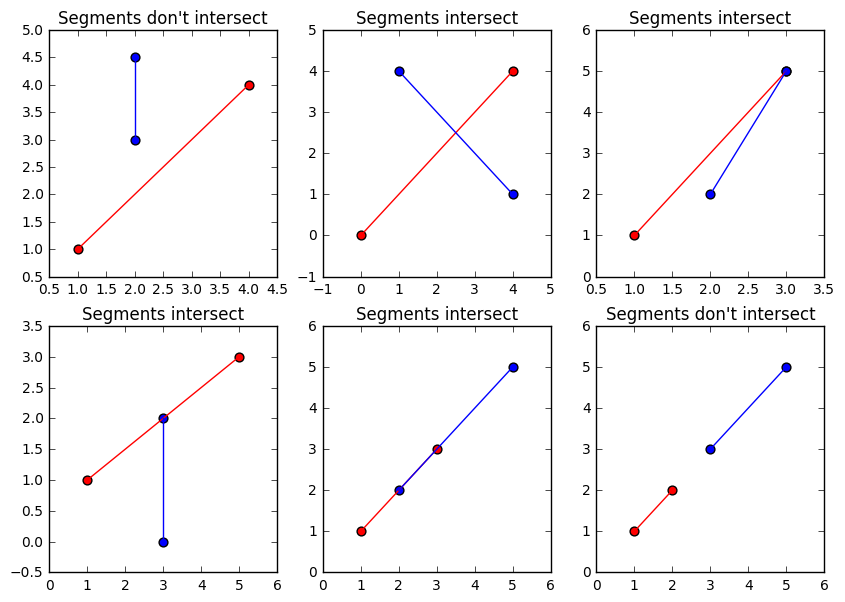

In [19]:
import matplotlib.pyplot as plt
import numpy as np
from decimal import *

getcontext().prec = 70

class Point:
    def __init__(self, x = 0.0, y = 0.0):
        self.x = x
        self.y = y
        
    def __sub__(self, p):
        return Point(self.x - p.x, self.y - p.y)

    def __repr__(self):
        return "(%r, %r)" % (self.x, self.y)

class Segment:
    def __init__(self, a, b):
        self.a = a
        self.b = b
        
    def __lt__(self, s):
        return self.a < s.a or self.a == s.a and self.b < s.b

    def __repr__(self):
        return "[%r, %r]" % (self.a, self.b)

def calculate_det(a, b):
    return a.x * b.y - b.x * a.y

def calculate_arg(a, b):
    return abs(a.x * b.y) + abs(b.x * a.y)

def turn(s, c):
    a = s.a
    b = s.b
    e = 8 * np.finfo(float).eps * calculate_arg(b - a, c - a)
    det = calculate_det(b - a, c - a)
    if det > e:
        return 1
    if det < -e:
        return -1

    la = Point(Decimal(a.x), Decimal(a.y))
    lb = Point(Decimal(b.x), Decimal(b.y))
    lc = Point(Decimal(c.x), Decimal(c.y))
    ldet = calculate_det(lb - la, lc - la)
    if ldet > 0:
        return 1
    if ldet < 0:
        return -1
    return 0

def convert_by_x(s):    # s.a.x <= s.b.x
    if s.a.x > s.b.x:
        s.a, s.b = s.b, s.a
    return s

def convert_by_y(s):    # s.a.y <= s.b.y
    if s.a.y > s.b.y:
        s.a, s.b = s.b, s.a
    return s

def bounding_box(s1, s2):
    convert_by_x(s1)
    convert_by_x(s2)
    if not (s1.a.x <= s2.b.x and s1.b.x >= s2.a.x):
        return 0
    convert_by_y(s1)
    convert_by_y(s2)
    if not (s1.a.y <= s2.b.y and s1.b.y >= s2.a.y):
        return 0
    return 1

def check_intersection(s1, s2):
    if bounding_box(s1, s2) == 0:
        return 0
    if turn(s1, s2.a) * turn(s1, s2.b) > 0:
        return 0
    if turn(s2, s1.a) * turn(s2, s1.b) > 0:
        return 0
    return 1

f, axes = plt.subplots(2, 3, figsize=(10, 7))
with open("2_segments.in") as inp:
    n = int(inp.readline())  # number of tests
    for i, axis in zip(range(0, n), axes.reshape((6))):
        x1, y1, x2, y2 = map(float, inp.readline().split())
        s1 = Segment(Point(x1, y1), Point(x2, y2))
        axis.scatter(x1, y1, c = 'r', s = 40)
        axis.scatter(x2, y2, c = 'r', s = 40)
        axis.plot([x1, x2], [y1, y2], c = 'r')
        x3, y3, x4, y4 = map(float, inp.readline().split())
        s2 = Segment(Point(x3, y3), Point(x4, y4))
        axis.scatter(x3, y3, c = 'b', s = 40)
        axis.scatter(x4, y4, c = 'b', s = 40)
        axis.plot([x3, x4], [y3, y4], c = 'b')
        axis.set_title("Segments intersect" if check_intersection(s1, s2) != 0 else "Segments don't intersect")

plt.show()

На этом вступление заканчивается, и мы переходим к основной части конспекта, в которой будут разобраны более существенные и интересные задачи.

### Алгоритм Бенли-Оттмана
Данный алгоритм позволяет решить задачу, которая была аннонсирована во вступлении. Напомню ее формулировку: дано множество $S = \{ s_1, s_2, \dots s_n \}$, состоящее из $n$ отрезков на плоскости. Нужно найти множество точек, в которых эти отрезки пересекаются. 

Заметим, что пересекаться могут только ближайшие отрезки, поэтому нет смысла проверять на наличие пересечения отрезки, находящиеся далеко друг от друга. Для начала оформально определим понятия "ближайших" и "находящихся далеко друг от друга" отрезков. Будем рассматривать ортогональные проекции отрезков на ось $X$. Если проекции двух отрезков не пересекаются, то будем говорить, что такие отрезки далеко друг от друга (очевидно, они не могут иметь общих точек). Следовательно, мы должны рассматривать только те отрезки, проекции которых пересекаются, то есть существует параллельная оси $Y$ прямая, пересекающая оба отрезка. Чтобы найти все такие отрезки, представим прямую $l$, скользящую по плоскости параллельно оси $Y$, начинающую свое движение из $-\infty$. Эта прямая называется заметающей прямой (*sweep line*). Благодаря ей мы сможем отслеживать интересующие нас отрезки в каждый момент времени, что позволит нам найти все пересечения.

Будем называть статусом заметающей прямой множество отрезков, пересекающих заметающую прямую в данный момент времени. Статус меняется при достижении так называемых событий (*event points*), для нас событиями являются точки начала и конца отрезков.

На самом деле алгоритм совершает какие-то дейтвия только при достижении $l$ события: обновляется статус прямой и происходят проверки отрезков из множества на наличие пересечений. Например, если событие - "левый конец отрезка" $s_i$, то $s_i$ добавляется в статус и проверяется на пересечение с другими; при достижении события "правый конец" $s_i$ будет удален из множества. Однако такой алгоритм все еще не output-sensitive, поскольку есть ситуации, при которых происходит проверка $O(n^2)$ пар отрезков, хотя пересечений на самом деле много меньше: простейший пример - множество горизонтальных отрезков, пересекающих ось $Y$. Проблема в том, что два отрезка, пересекающих заметающую прямую, могут находиться далеко друг от друга в вертикальном направлении. 

Упорядочим отрезки, пересекающие заметающую прямую, снизу вверх: зависимости от типа события, будем брать нужный конец отрезка и сравнивать его с остальными, в случае равенства точек, будем считать, что событие "левый конец" меньше. Точки будем сравнивать самым обычным образом:
$$ a < b \Longleftrightarrow \left[ 
  \begin{gathered} 
    a.x < b.x \\ 
    a.x = b.x \wedge a.y < b.y \\ 
  \end{gathered} 
\right. $$
Таким образом, мы сможем отсечь отрезки, находящиеся далеко в вертикальном направлении. Соответственно, мы будем проверять на наличие пересечения только ближайшие в обоих направлениях отрезки. 

Теперь соберем все вместе и опишем алгоритм более формально:

0. Заранее оговорим, что левый конец отрезка является его началом, правый - концом.
1. Из множества входных отрезков $S$ построим множество событий $events$, в котором каждый отрезок будет встречаться два раза - одно событие будет отвечать за его левый конец, другое - за правый.
2. Отсортируем $events$ по неубыванию. 
3. Инициализируем $status$ пустым множеством. Для статуса нужна такая структура данных, которая бы позволила хранить элементы в отсортированном порядке и вставлять/извлекать данные не хуже, чем за $O(\log{m})$, где $m$ - количество отрезков в статусе. Например, можно использовать сбалансированное бинарное дерево поиска. 
4. Будем идти по отсортированному множеству событий. Каждое новое событие $e$ будем обрабатывать следующим образом:
 1. Проверяем, какого типа событие (начало или конец отрезка) мы встретили. Пусть инициатором этого события является отрезок $s$.
 2. Если событие - левый конец, то делаем следующее:
    1. Если $status = \varnothing$, то просто добавляем $s$ в статус и переходим к следующему событию.
    2. В противном случае нам нужно найти соседей $s$ и проверить отрезки на наличие пересечений. Находим в статусе минимальный элемент, больший $s$ (если такого нет - берем максимальный). Пусть это будет отрезок $t$. Если $t$ - крайний элемент статуса (максимальный или минимальный), то мы проверяем пересечение только с ним. Если нет - то нужно проверить пересечение $s$ не только с $t$, но и с отрезком, идущим в статусе перед $t$ (то есть с соседями сверху и снизу).
    3. После проверки добавляем $s$ в статус.
    4. Переходим к следующему событию.
 3. Если событие - правый конец:
    1. Удаляем отрезок из статуса
    2. Теперь у двух отрезков могли поменяться соседи, поэтому если в статусе больше одного отрезка, то снова находим в статусе $t$ - минимальный элемент, больший $s$. Если такого нет, переходим к следующему событию. Если есть и он не крайний минимальный, то проверяем, пересекается ли он со своим нижним соседом.
    3. Переходим к следующему событию.
    
После того, как будет обработано последнее событие, алгоритм завершает свою работу. Стоит учесть, что какие-то отрезки могут становиться соседями больше одного раза, и корректно обрабатывать такие ситуации.    

Точку пересечения $q$ двух непараллельных отрезков $a_1 b_1$ и $a_2 b_2$ можно найти следующим образом:

\begin{equation} 
\left( \begin{array}{cc}
   a_1.y - b_1.y & b_1.x - a_1.x\\
   a_2.y - b_2.y & b_2.x - a_2.x
\end{array} \right) 
\cdot 
\left( \begin{array}{c}
   x\\
   y
\end{array} \right) =
\left( \begin{array}{c}
   (a_1.y - b_1.y) \cdot a_1.x + (b_1.x - a_1.x) \cdot a_1.y\\
   (a_2.y - b_2.y) \cdot a_2.x + (b_2.x - a_2.x) \cdot a_2.y
\end{array} \right) \end{equation}

\begin{equation} \left( \begin{array}{c}
   x\\
   y
\end{array} \right) = \large  
\frac{
\left( \begin{array}{cc}
b_2.x - a_2.x & a_1.x - b_1.x\\
b_2.y - a_2.y & a_1.y - b_1.y
\end{array} \right) 
\cdot
\left( \begin{array}{c}
b_1.x \cdot a_1.y - b_1.y \cdot a_1.x\\
b_2.x \cdot a_2.y - b_2.y \cdot a_2.x
\end{array} \right) 
}{
\left| \begin{array}{cc}
a_1.y - b_1.y & b_1.x - a_1.x\\
a_2.y - b_2.y & b_2.x - a_2.x
\end{array} \right| } \end{equation}

Теперь, перед тем, как реализовывать алгоритм, нам нужно доказать корректность его работы.

**Теорема**<br>
Пусть $s_i$ и $s_j$ - два пересекающихся в точке $p$ отрезка. Предположим, что нет третьего отрезка, проходящего через $p$. Тогда существует событие, которое случится раньше, чем заметающая прямая $l$ достигнет $p$, при котором $s_i$ и $s_j$ станут соседями и будут проверены на пересечение.

**Доказательство**<br>
$\triangleright$<br><div style="padding-left:40px"> Пусть $l$ находится строго левее $p$. Если $l$ достаточно близка к $p$, то $s_i$ и $s_j$ должны быть соседями (более формально мы должны влять такое положение $l$, при котором между ней и вертикальной прямой, параллельной оси $Y$ и проходящей через точку $p$, нет событий). Другими словами, существует такое положение заметающей прямой, в котором отрезки будут соседями. С другой стороны $s_i$ и $s_j$ не были соседями, когда $l$ начинала свое движение, поскольку она стартует левее всех точек. Следовательно, по ходу ее движение должно было произойти событие $q$, при котором $s_i$ и $s_j$ стали соседями и были проверены на пересечение. </div> 
$\triangleleft$

Теперь мы понимаем, что в таком виде алгоритм не находит пересечения трех и более отрезков, имеющих одну общую точку. То есть этот алгоритм можно использовать для ответа на вопрос "есть ли в множестве такая пара отрезков, которая пересекается?", но чтобы найти все пересечения, нужно добавить еще один шаг. Добавим к событиям еще один тип - пересечение отрезков. Будем проверять,  если событие - это точка пересечения двух отрезков, то эти отрезки меняют порядок и у каждого появляется, возможно, новый сосед. Мы проверим каждую пару новых соседей в статусе на пересечение. Нас будут интересовать только пересечения правее заметающей прямой.

**Теорема**<br>
Алгоритм находит все точки точки пересечения и отрезки, которые их содержат. 

**Доказательство**<br>
$\triangleright$<br><div style="padding-left:40px"> Воспользуемся индукцией по событиям, отсортированным в порядке $ q < p \Longleftrightarrow \left[ 
  \begin{gathered} 
    q.x < p.x \\ 
    q.x = p.x \wedge q.y < p.y \\ 
  \end{gathered} 
\right. $. Предположим что все события $q : q < p$ были обработаны корректно. Докажем, что $p$ и отрезки, содержащие $p$, будут обработаы корректно. 
1. Если событие $p$ - точка пересечения отрезков, то по предыдущей теореме найдется предшествующее $p$ событие $q$ такое, что при его обработке пара отрезков, пересекающихся в $p$, будут соседними в статусе. Следовательно, в этом случае $p$ будет обнаружена.
2. Если $p$ - начало или конец отрезка, то она была добавлена в $events$ в самом начале работы алгоритма. Все содержащие её отрезки из статуса в момент обработки $p$ будут найдены. Для остальных отрезков, содержащих $p$, верно, что $p$ — их левый конец, и они будут найдены, так как мы храним их вместе с $p$ в $events$. </div> 
$\triangleleft$

**Теорема**<br>
Время работы алгоритма - $O((n + I)\log{n})$, где $I$ - количество пересечений.

**Доказательство**<br>
$\triangleright$<br><div style="padding-left:40px"> 
На первом шаге алгорим строит множество событий $events$, вместе с сортировкой (или при использовании сбалансированного бинарного дерева в качестве структуры данных) это выполняется за $O(n\log{n})$. Инициализация статуса занимает константное время. 

Далее на каждой итерации мы обрабатываем по одному событию. Обработка может включать в себя удаление отрезка из статуса за $O(\log{n})$ и проверку на пересечение отрезка с не более, чем двумя соседями, что может вызвать вставку новых событий (снова $O(\log{n})$). Всего при обработке события $p$ мы $m(p) = \mid L(p) \cup C(p) \cup U(p) \mid$ раз выполняем операции вставки, удаления и поиска отрезка в статусе, где $L(p)$ - множество отрезков, верхний конец которых есть $p$, $C(p)$ - множество отрезков, внутри которых содержится $p$, и $U(p)$ - множество отрезков, нижний конец которых есть $p$. Пусть $m = \sum_{p}^{}m(p)$. Тогда время работы алгоритма - $O(n\log{n} + m\log{n})$. Осталось показать, что $m = n + I$.

Рассмотрим планарный граф, вершинами которого являются концы отрезков, а также их точки пересечения, а ребрами - части отрезков, их соединяющие. Рассмотрим событие $p$. Ему соответствует вершина графа со степенью $O(m(p))$. Следовательно, $m$ не превосходит суммы степеней всех вершин графа: $m = O(\sum_{p}^{}deg(p))$. Каждое ребро графа добавляет $+1$ к степени ровно двух вершин, из чего следует, что $m = O(2\mid E \mid) = O(\mid E \mid)$, где $\mid E \mid$ - количество ребер в графе. Пусть $\mid V \mid$ - количество вершин в графе, тогда $\mid V \mid \leqslant 2n + I$. Мы знаем, что в планарном графе $\mid E \mid = O(\mid V \mid)$. Таким образом, $O(\mid E \mid) = O(\mid V \mid) = O(2n + I)$. Следовательно, время работы алгоритма - $O((n + I)\log{n})$. </div>
$\triangleleft$

Теперь перейдем к практической реализации описанного алгоритма. Здесь будет дан каркас, читателю в качестве тренировки предлагается самому дописать недостающую часть.

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
from decimal import *
from enum import Enum
from blist import sortedset

getcontext().prec = 70
step = 5
Type = Enum('Type', 'left right inter')

class Type(Enum):
    left = 0
    right = 1
    inter = 2
    
    def __lt__(self, other):
        return self.value < other.value

class Point:
    __slots__ = ("x", "y")

    def __init__(self, x = 0.0, y = 0.0):
        self.x = x
        self.y = y

    def __sub__(self, p):
        return Point(self.x - p.x, self.y - p.y)

    def __lt__(self, p):
        return self.x < p.x or self.x == p.x and self.y < p.y

    def __eq__(self, p):
        return self.x == p.x and self.y == p.y

    def __gt__(self, p):
        return not (self < p or self == p)

    def __repr__(self):
        return "(%r, %r)" % (self.x, self.y)

class Segment:
    __slots__ = ("a", "b", "id")

    def __init__(self, a, b, id):
        self.a = min(a, b)
        self.b = max(a, b)
        self.id = id

    def __lt__(self, s):
        if s is None:
            return False
        if self.id == s.id:
            return False
        if self.a == s.a:
            return self.b < s.b
        return self.a < s.a

    def __eq__(self, s):
        return self.id == s.id

    def __gt__(self, p):
        return not (self < p or self == p)

    def __repr__(self):
        return "[%r, %r]" % (self.a, self.b)

class Event:
    __slots__ = ("segment", "t", "addit_segment", "inter_point")        # addit_segment & inter_point are used only for type = inter

    def __init__(self, segment, t, addit_segment = None, inter_point = None):
        self.segment = segment
        self.t = t

    def __lt__(self, e):
        a = self.segment.a if self.t == Type.left else \
            self.segment.b if self.t == Type.right else self.inter_point
        b = e.segment.a if e.t == Type.left else \
            e.segment.b if e.t == Type.right else e.inter_point
        if a == b:
            if self.t == e.t:
                if self.segment == e.segment:
                    return self.addit_segment < e.addit_segment
                return self.segment < e.segment
            return self.t < e.t
        return a < b

    def __eq__(self, e):
        return self.segment.id == e.segment.id and self.t == e.t

    def __gt__(self, e):
        return not (self < e or self == e)

    def __repr__(self):
        if type != Type.inter:
            return "Event [%r, type = %r]" % (self.segment, self.t)
        return "Event inter [%r, %r, point = %r]" % (self.segment, self.addit_segment, self.inter_point)

max_x = max_y = min_x = min_y = 0
events = []
with open("segments_set.in") as inp:
    n = int(inp.readline())  # number of segments
    for i in range(0, n):
        x1, y1, x2, y2 = map(float, inp.readline().split())
        s = Segment(Point(x1, y1), Point(x2, y2), i)
        events.append(Event(s, Type.left))
        events.append(Event(s, Type.right))
        max_x = max(max_x, x1, x2)
        max_y = max(max_y, y1, y2)
        min_x = min(min_x, x1, x2)
        min_y = min(min_y, y1, y2)
        plt.plot([x1, x2], [y1, y2])

events.sort()
status = sortedset()
intersections = set()

for e in events:
    line_segment = e.segment
    if e.t == Type.left:
        # Находим соседей отрезка сверху и снизу, и, если они есть,
        # проверяем отрезки на наличие пересечения. Добавляем
        # новые события в статус.
        status.add(line_segment)
    if e.t == Type.right:
        status.remove(line_segment)
        # Если у каких-то отрезков поменялись соседи,
        # проверим их. Добавляем новые события
        # в статус.
    if e.t == Type.inter:
        # Меняем порядок отрезков и проверяем
        # каждую пару новых соседей. Новые пересечения
        # добавляем в статус.

plt.axis([min_x - step, max_x + step, min_y - step, max_y + step])
plt.show()